## 线性回归从零实现（不实用深度学习框架，仅使用tensor）

包括：数据流水线、模型、损失函数、小批量梯度下降优化器

In [1]:
%matplotlib inline
import random
import torch
import numpy
from d2l import torch as d2l

In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

构造一个人造数据集，线性参数 $ w=[2,-3.4]^T $ $b=4.2$和噪声项θ

In [3]:
def synthetic_data(w, b, num_examples): 
    """生成 y = Xw + b + 噪声。"""
    X = torch.normal(0, 1, (num_examples, len(w))) #均值为0，方差为1，n个样本，列数为w长度
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))#返回x和一个列向量


true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [4]:
print("features:",features[0],"\nlabelL:",labels[0])

features: tensor([-1.8279, -0.0063]) 
labelL: tensor([0.5571])


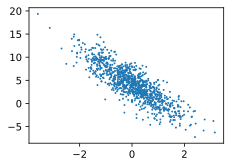

In [5]:
d2l.set_figsize()
d2l.plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1)

In [6]:
#定义一个data_iter 函数， 该函数接收批量大小、特征矩阵和标签向量作为输入，生成大小为batch_size的小批量]
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

In [7]:
#体验第一个batch
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 0.1484, -0.5081],
        [-0.4759,  0.3286],
        [-0.8929, -0.2844],
        [ 2.3341, -0.6758],
        [ 0.8978, -0.3442],
        [ 0.5087,  0.6523],
        [-0.9241,  0.5189],
        [ 0.5717,  0.4044],
        [-0.2154, -1.4513],
        [-0.1984,  0.3551]]) 
 tensor([[ 6.2183],
        [ 2.1298],
        [ 3.3911],
        [11.1744],
        [ 7.1730],
        [ 3.0044],
        [ 0.5860],
        [ 3.9704],
        [ 8.7006],
        [ 2.6134]])


In [8]:
#初始化模型参数
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

In [9]:
#定义线性回归模型
def linreg(X, w, b):  
    return torch.matmul(X, w) + b

In [10]:
#均方损失。
def squared_loss(y_hat, y):  #@save
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

In [11]:
#小批量随机梯度下降。
def sgd(params, lr, batch_size):  #@save
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

In [12]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # `X`和`y`的小批量损失
        # 因为`l`形状是(`batch_size`, 1)，而不是一个标量。`l`中的所有元素被加到一起，
        # 并以此计算关于[`w`, `b`]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # 使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.046076
epoch 2, loss 0.000202
epoch 3, loss 0.000051


In [13]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([-0.0003, -0.0012], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0005], grad_fn=<RsubBackward1>)


## 利用pytorch简洁实现


In [14]:
import numpy as np
import torch
from torch.utils import data
from d2l import torch as d2l

In [15]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w, true_b, 1000)

In [16]:
def load_array(data_arrays, batch_size, is_train=True):  #@save
    """构造一个PyTorch数据迭代器。"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

In [17]:
batch_size = 10
data_iter = load_array((features, labels), batch_size)

In [18]:
next(iter(data_iter))

[tensor([[ 0.2665, -0.4900],
         [ 0.4855,  0.3323],
         [-0.6974, -0.9991],
         [ 0.5281, -0.4071],
         [ 1.5824, -0.8126],
         [-0.6592, -0.5515],
         [-0.0627,  0.7095],
         [-0.1451, -0.6715],
         [ 1.1137,  0.7389],
         [ 1.2458, -0.4420]]),
 tensor([[ 6.4119],
         [ 4.0544],
         [ 6.2072],
         [ 6.6292],
         [10.1183],
         [ 4.7449],
         [ 1.6561],
         [ 6.1941],
         [ 3.9203],
         [ 8.1937]])]

In [19]:
#定义模型
#nn是神经网络的缩写
from torch import nn
net = nn.Sequential(nn.Linear(2, 1))

In [20]:
#初始化参数
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

tensor([0.])

In [21]:
#[计算均方误差使用的是MSELoss类，也称为平方  𝐿2范数]。默认情况下，它返回所有样本损失的平均值。
loss = nn.MSELoss()

In [22]:
#定义优化算法
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

In [23]:
#训练
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X) ,y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')

epoch 1, loss 0.000218
epoch 2, loss 0.000097
epoch 3, loss 0.000099


In [24]:
w = net[0].weight.data
print('w的估计误差：', true_w - w.reshape(true_w.shape))
b = net[0].bias.data
print('b的估计误差：', true_b - b)

w的估计误差： tensor([ 1.0633e-03, -5.9605e-05])
b的估计误差： tensor([0.0016])
